<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1b_retropropagacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retropropagación de errores

En este *notebook* programaremos con NumPy una red neuronal densa y la entrenaremos para aproximar la operación XOR usando del gradiente descedente con el algoritmo de retropropagación de errores. Recordemos que la operación XOR ($\otimes$) está de la siguiente manera:

| $x_1$ | $x_2$ | $y$
| ------------- |:-------------:| -----:|
|0 |0 |0|
|0 |1 |1|
|1 |0 |1|
|1 |1 |0|


In [0]:
import numpy as np

Nuestra red neuronal densa está compuesta por una capa de 2 entradas ($x_1$ y $x_2$), una capa oculta con 10 neuronas con función de activación sigmoide y una capa de salida con una sola neurona con función de activación sigmoide. Esta función de activación se define como:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [0]:
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

La función sigmoide tiene una derivada que está expresada en términos de la misma función, esto es, 

$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [0]:
def derivada_sigmoide(x):
    return np.multiply(sigmoide(x), (1.0 - sigmoide(x)))

Podemos ver la operación XOR como una tarea de clasificación binaria a partir de 2 entradas. Por lo tanto, usaremos la función de pérdida de entropía cruzada binaria:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [0]:
def entropia_cruzada_binaria(y, p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

Asimismo, calcularemos la exactitud para medir el rendimiento del modelo aprendido por la red neuronal densa:

$$
exactitud = \frac{correctos}{total}
$$

In [0]:
def exactitud(y, y_predicha):
    return (y == y_predicha).mean() * 100

Ahora, definimos la función que propaga hacia adelante una entrada $\mathbf{x}^{i}$. Como la red está compuesta de 2 capas densas (1 oculta y 1 de salida), tenemos 2 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}}, \mathbf{b}^{\{1\}}\}$ y $\{\mathbf{W}^{\{2\}}, \mathbf{b}^{\{2\}}\}$ de la capa oculta y la capa de salida respectivamente. Así, podemos llevar a cabo la propagación hacia adelante en esta red de la siguiente manera:

$$
	\begin{split}
				\mathbf{a}^{\{1\}} & =  \mathbf{x}^{(i)} \\
				\mathbf{z}^{\{2\}} & =  \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{a}^{\{2\}} & =  \sigma(\mathbf{z}^{\{2\}}) \\
				\mathbf{z}^{\{3\}} & =  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{a}^{\{3\}} & =  \sigma(\mathbf{z}^{\{3\}})\\
				\hat{y}^{(i)} & =  \mathbf{a}^{\{3\}}
			\end{split}
      $$

In [0]:
def hacia_adelante(x, W1, b1, W2, b2):
  z2 = np.dot(W1.T, x[:, np.newaxis]) + b1
  a2 = sigmoide(z2)
  z3 = np.dot(W2.T, a2) + b2
  y_hat = sigmoide(z3)
  
  return z2, a2, z3, y_hat

Finalmente, definimos la función para entrenar nuestra red neuronal usando gradiente descendente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de retropropagación de errores.



In [0]:
def retropropagacion(X, y, alpha = 0.01, n_epocas = 100, n_ocultas = 10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]
    
    # Inicialización de las matrices de pesos W y V
    W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
    b1 = np.zeros((n_ocultas, 1))
    
    W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
    b2 = np.zeros((1, 1))
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, y_hat = hacia_adelante(X[j], W1, b1, W2, b2)

            # cálculo de gradiente para W2 por retropropagación
            delta3 = (y_hat - y[j]) * derivada_sigmoide(z3)
            W2 = W2 - alpha * np.outer(a2, delta3)
            b2 = b2 - alpha * delta3

            # cálculo de gradiente para W1 por retropropagación
            delta2 = np.dot(W2, delta3) * derivada_sigmoide(z2)
            W1 = W1 - alpha * np.outer(X[j], delta2)
            b1 = b1 - alpha * delta2

            y_predicha[j] = y_hat
            
        # calcula error en época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, np.round(y_predicha))
        print('Epoch {0}: Error = {1} Exactitud = {2}'.format(i, 
                                                              perdidas[i], 
                                                              exactitudes[i]))

    return W1, W2, perdidas, exactitudes

Para probar nuestra red, generamos los ejemplos correspondientes a la operación XOR.

In [0]:
# ejemplo (XOR)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

Finalmente, entrenamos nuestra red con estos ejemplos por 50000 épocas usando una tasa de aprendizaje $\alpha = 0.01$.

In [9]:
np.random.seed(0)
W1, W2, perdidas, exactitudes = retropropagacion(X, 
                                                 y, 
                                                 alpha = 0.01, 
                                                 n_epocas = 50000,
                                                 n_ocultas = 10)

Epoch 0: Error = 2.830028482419709 Exactitud = 50.0
Epoch 1: Error = 2.8287118318814253 Exactitud = 50.0
Epoch 2: Error = 2.8274228991582673 Exactitud = 50.0
Epoch 3: Error = 2.8261611531633832 Exactitud = 50.0
Epoch 4: Error = 2.824926070621199 Exactitud = 50.0
Epoch 5: Error = 2.823717136053868 Exactitud = 50.0
Epoch 6: Error = 2.8225338417625956 Exactitud = 50.0
Epoch 7: Error = 2.821375687804113 Exactitud = 50.0
Epoch 8: Error = 2.8202421819625143 Exactitud = 50.0
Epoch 9: Error = 2.819132839716709 Exactitud = 50.0
Epoch 10: Error = 2.8180471842037007 Exactitud = 50.0
Epoch 11: Error = 2.8169847461779307 Exactitud = 50.0
Epoch 12: Error = 2.8159450639668955 Exactitud = 50.0
Epoch 13: Error = 2.814927683423245 Exactitud = 50.0
Epoch 14: Error = 2.8139321578735768 Exactitud = 50.0
Epoch 15: Error = 2.8129580480641083 Exactitud = 50.0
Epoch 16: Error = 2.812004922103445 Exactitud = 50.0
Epoch 17: Error = 2.8110723554026005 Exactitud = 50.0
Epoch 18: Error = 2.8101599306124774 Exactitu

Graficamos el valor de la pérdida y la exactitud en cada época para ver el comportamiento de nuestra red durante el entrenamiento:

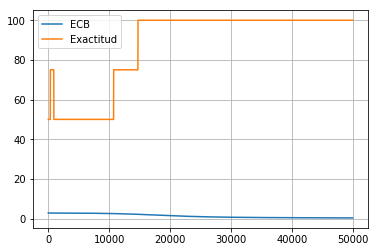

In [10]:
import matplotlib.pyplot as plt
plt.plot(np.arange(50000), perdidas, label='ECB')
plt.plot(np.arange(50000), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

## Inicializando los pesos con zeros
Como se mencionó anteriormente, las matrices de pesos $\mathbf{W^{\{1\}}}$ y $\mathbf{W^{\{2\}}}$ se initializan con valores aleatorios pequeños mientras que los vectores de sesgo $\mathbf{b^{\{1\}}}$ y $\mathbf{b^{\{1\}}}$ con zeros. Examinemos qué pasa si inicializamos las matrices de pesos con zeros. Observa los valores de los pesos en cada época.

In [0]:
def retropropagacion_zeros(X, y, alpha = 0.1, n_epocas = 100, n_ocultas = 10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]
    
    # Inicializa matrices de pesos W1 y W2 y vectores de sesgos b1 y b2
    W1 = np.zeros((n_entradas, n_ocultas))
    b1 = np.zeros((n_ocultas, 1)) 
    W2 = np.zeros((n_ocultas, 1))
    b2 = np.zeros((1, 1))
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, y_hat = hacia_adelante(X[j], W1, b1, W2, b2)

            # cálculo de gradiente para W2 por retropropagación
            delta3 = (y[j] - y_hat) * derivada_sigmoide(z3)
            W2 = W2 - alpha * np.outer(a2, delta3)
            b2 = b2 - alpha * delta3
            
            # calculo de gradiente para W1 por retropropagación
            delta2 = np.dot(W2, delta3) * derivada_sigmoide(z2)
            W1 = W1 - alpha * np.outer(X[j], delta2)
            b1 = b1 - alpha * delta2
            
            y_predicha[j] = y_hat
            
        # calcula error en época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, np.round(y_predicha))
        print('Epoch {0}: Error = {1} Exactitud = {2}'.format(i, 
                                                              perdidas[i], 
                                                              exactitudes[i]))
        print('W1 = {0}'.format(W1))
        print('W2 = {0}'.format(W2))
            
    return W1, W2, perdidas, exactitudes, y_predicha

In [12]:
W1, W2, perdidas, exactitudes = retropropagacion_zeros(X, 
                                                       y, 
                                                       alpha = 0.01,
                                                       n_epocas = 5,
                                                       n_ocultas = 10)

W2 = [[0.000625]
 [0.000625]
 [0.000625]
 [0.000625]
 [0.000625]
 [0.000625]
 [0.000625]
 [0.000625]
 [0.000625]
 [0.000625]]
W1 = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
W2 = [[1.37010868e-06]
 [1.37010868e-06]
 [1.37010868e-06]
 [1.37010868e-06]
 [1.37010868e-06]
 [1.37010868e-06]
 [1.37010868e-06]
 [1.37010868e-06]
 [1.37010868e-06]
 [1.37010868e-06]]
W1 = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.27220323e-10 -4.27220323e-10 -4.27220323e-10 -4.27220323e-10
  -4.27220323e-10 -4.27220323e-10 -4.27220323e-10 -4.27220323e-10
  -4.27220323e-10 -4.27220323e-10]]
W2 = [[-0.00062363]
 [-0.00062363]
 [-0.00062363]
 [-0.00062363]
 [-0.00062363]
 [-0.00062363]
 [-0.00062363]
 [-0.00062363]
 [-0.00062363]
 [-0.00062363]]
W1 = [[ 1.94882489e-07  1.94882489e-07  1.94882489e-07  1.94882489e-07
   1.94882489e-07  1.94882489e-07  1.94882489e-07

## Tarea
Modifica el código anterior para agregar una capa extra de neuronas ocultas.
